In [1]:
import pandas as pd
from scipy.stats import hmean

# Load the Excel file into a DataFrame
file_path = "/Users/marclambertes/Downloads/DB2425/NL1.xlsx"
df = pd.read_excel(file_path)

# Drop rows with NaN values in the specified columns
df.dropna(subset=['Back passes per 90', 'Lateral passes per 90', 'Short / medium passes per 90'], inplace=True)
df = df[(df['Position'].isin(['CF'])) & (df['Minutes played'] >= 500)]

# Filter out rows where any of the metrics are zero
df = df[(df['Back passes per 90'] != 0) & 
        (df['Lateral passes per 90'] != 0) & 
        (df['Short / medium passes per 90'] != 0)]

# Calculate harmonic mean for each player
df['Harmonic Mean'] = hmean(df[['Back passes per 90', 'Lateral passes per 90', 'Short / medium passes per 90']], axis=1)

# Scale the harmonic mean to a range of 0-100
min_hmean = df['Harmonic Mean'].min()
max_hmean = df['Harmonic Mean'].max()

df['Harmonic Mean (Scaled)'] = 100 * (df['Harmonic Mean'] - min_hmean) / (max_hmean - min_hmean)

# Print player names along with their specific scaled harmonic mean
for index, row in df.iterrows():
    print(f"Player: {row['Player']}, Scaled Harmonic Mean: {row['Harmonic Mean (Scaled)']}")

# Save the DataFrame to an Excel file
df.to_excel("/Users/marclambertes/Downloads/CPI Eredivisie.xlsx", index=False)


Player: B. Brobbey, Scaled Harmonic Mean: 61.99535364823748
Player: W. Weghorst, Scaled Harmonic Mean: 96.27105476686572
Player: S. Lammers, Scaled Harmonic Mean: 71.41038196159899
Player: T. Lauritsen, Scaled Harmonic Mean: 28.082844488931535
Player: T. Parrott, Scaled Harmonic Mean: 67.61579081599312
Player: L. de Jong, Scaled Harmonic Mean: 100.0
Player: K. Ogawa, Scaled Harmonic Mean: 0.745958284727347
Player: N. Ohio, Scaled Harmonic Mean: 61.8518144981499
Player: I. Nicolăescu, Scaled Harmonic Mean: 21.532974516600554
Player: T. Robinet, Scaled Harmonic Mean: 12.511553214264305
Player: D. Min, Scaled Harmonic Mean: 65.03640183380166
Player: D. Vente, Scaled Harmonic Mean: 49.647395072667614
Player: V. Edvardsen, Scaled Harmonic Mean: 68.25663096159464
Player: R. Postema, Scaled Harmonic Mean: 47.89574842211174
Player: K. Vaesen, Scaled Harmonic Mean: 14.669862454607392
Player: O. Zawada, Scaled Harmonic Mean: 55.26901867173371
Player: E. Ómarsson, Scaled Harmonic Mean: 14.8108545

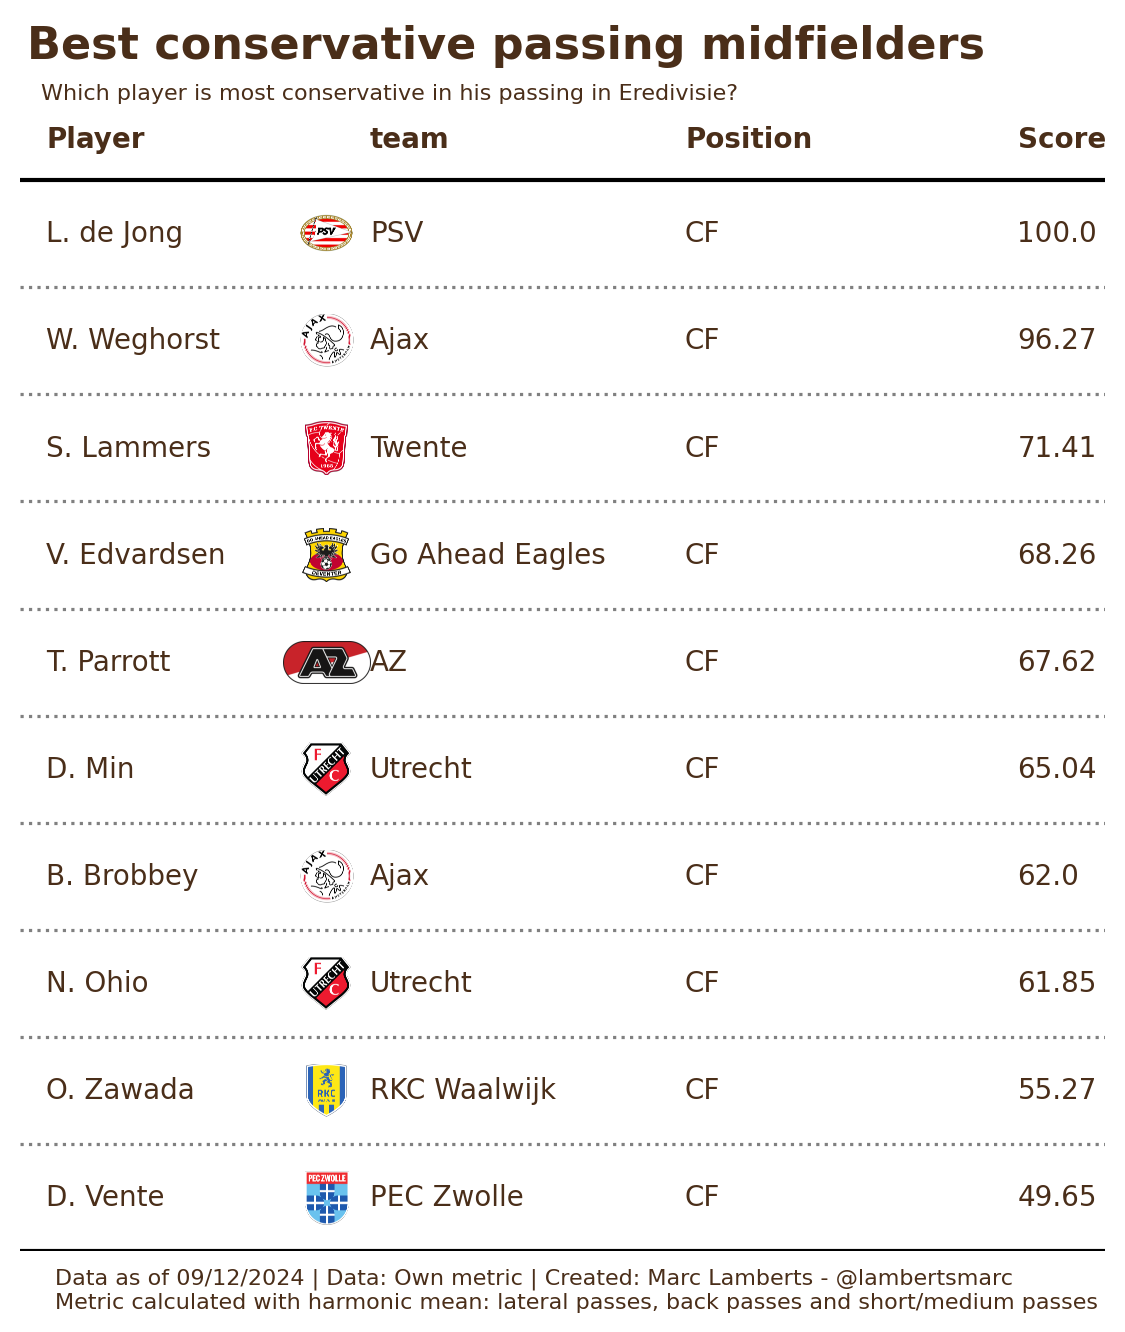

In [2]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter


df = pd.read_excel('/Users/marclambertes/Downloads/CPI Eredivisie.xlsx')
#df = df.rename(columns={'Scaled Harmonic Mean': 'Score'})
df = df.rename(columns={'Team within selected timeframe': 'team'})
df['Score'] = (df['Harmonic Mean (Scaled)']).round(2)
df = df.rename(columns={'playerName': 'Player'})
df = df.sort_values(by='Score', ascending=False).head(10)


def ax_logo(team, ax,):
    path = r'/Users/marclambertes/Downloads/Images'
    club_icon = Image.open('%s/%s.png' %(path,team))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

indexdf = df.head(10)[['Player', 'team', 'Position', 'Score']].reset_index(drop=True)
indexdf_short=indexdf[::-1]


fig = plt.figure(figsize=(7,8), dpi=200)
ax = plt.subplot()

ncols = len(indexdf_short.columns.tolist())+1
nrows = indexdf_short.shape[0]

ax.set_xlim(0, ncols + 1.2)
ax.set_ylim(0, nrows + 1.5)

# lgs = ['J1', 'J2', 'Ekstraklasa', 'J3']
# if lg in lgs:
positions = [0.15, 2.0, 3.8, 5.7]
# else:
#     positions = [0.25, 2.25, 3.75, 4.5, 5.25]
columns = indexdf_short.columns.tolist()

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if 'xG per 90' in column:
            text_label = f'{indexdf_short[column].iloc[i]:,.2f}'
            weight = 'regular'
        else:
            text_label = f'{indexdf_short[column].iloc[i]}'
            weight = 'regular'
        ax.annotate(
            xy=(positions[j], i + .5),
            text = text_label,
            ha='left',
            va='center', color='#4A2E19',
            weight=weight
        )

# Add column names
column_names = columns
for index, c in enumerate(column_names):
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha='left',
            va='bottom',
            weight='bold', color='#4A2E19'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

ax.set_axis_off()

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([1.5, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(indexdf_short['team'].iloc[x], flag_ax,)

fig.text(
    x=0.13, y=.85,
    s='Best conservative passing midfielders',
    ha='left',
    va='bottom',
    weight='bold',
    size=16, color='#4A2E19'
)
fig.text(
    x=0.15, y=0.10,
    s='Data as of 09/12/2024 | Data: Own metric | Created: Marc Lamberts - @lambertsmarc\nMetric calculated with harmonic mean: lateral passes, back passes and short/medium passes',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

fig.text(
    x=0.14, y=0.84,
    s='Which player is most conservative in his passing in Eredivisie?',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

plt.savefig('PDS - eer.png',dpi=750,bbox_inches = 'tight', facecolor='white')
#plt.savefig('Similar Players - Momiki.pdf', dpi=750, bbox_inches='tight', facecolor='white')